# Captum usage example using fastai, pytorch


In [ ]:
# download preptrained model and dataset
# also overrides when if downloaded again
import os
if not os.path.exists("oxford-iiit-pet.zip"):
  os.system('curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/oxford-iiit-pet.zip')
if not os.path.exists("resnet18_finetuned.pkl"):
  os.system('curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/resnet18_finetuned.pkl')

In [ ]:
# install needed dependancies
%%capture
%%bash
pip install fastai
pip install psutil
pip install captum
pip install matplotlib~=3.5.3

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from fastai.vision.all import PILImage, load_learner, untar_data, get_image_files, ImageDataLoaders, ClassificationInterpretation, Resize, cnn_learner, URLs, resnet18, error_rate

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
# we use as a example the pets dataset
if not os.path.exists("./oxford-iiit-pet"):
  os.system('unzip -o oxford-iiit-pet.zip')

In [ ]:
# import dataset dataset contains dogs and cats
path = './oxford-iiit-pet/images'
imgs = get_image_files(path)

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, imgs, valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

In [ ]:
import os
if not os.path.exists("./resnet18_finetuned.pkl"):
  # if file does not exist finetune resnet18 on the dataset
  # finetune the model on the PETS dataset
  learn = cnn_learner(dls, resnet18, metrics=error_rate)
  learn.fine_tune(epochs=1)
  # Basic interpertation of the model prediected classes vs. actual ones.
  interp = ClassificationInterpretation.from_learner(learn)
  # Visualize top losses, e.g. to check if the images themselves are correctly annotated.
  interp.plot_confusion_matrix()
  interp.plot_top_losses(5, nrows=1)
  # save the model
  learn.export('./resnet18_finetuned.pkl')
else:
  # load the model
  learn_inf = load_learner('./resnet18_finetuned.pkl')

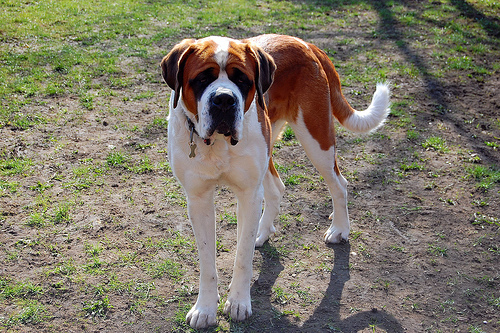

In [ ]:
# get random image
import random
idx = random.randint(0, len(imgs))
# cute
image = PILImage.create(imgs[idx])
image

In [ ]:
#convert to tensorimage
image = learn_inf.dls.after_item(image)
image = learn_inf.dls.after_batch(image)

In [ ]:
pred,pred_idx,probs = learn_inf.predict(imgs[idx])
pred, pred_idx, probs

('False', tensor(0), tensor([9.9999e-01, 5.6261e-06]))

## Interpretability
Let's use Captum.ai to interpret the model predictions and to have a visual on where the network focused more in the input image.

### Gradient-based attribution
Integrated Gradients is an interpretaility technique based on the approximation of integral gradients. The basic implementation works as followss:
* Given as input target image and a baseline image (usually a black image), generate multiple images between both starting from darker to lighter.
* Do forward pass with each of those images to predict a class and calculate the gradient.
* Approximate the integral of the gradients of all those images

The following example, illustrates how to use Captum `IntegratedGradients` to compute the attributions using Integrated Gradients and visualize them on the target image.

In [ ]:
integrated_gradients = IntegratedGradients(learn_inf.model)
attr_ig = integrated_gradients.attribute(image, target=pred_idx, n_steps=200)

In [ ]:
transposed_attr_ig = np.transpose(attr_ig.squeeze().numpy(), (1,2,0))
transposed_image = np.transpose(image.squeeze().numpy(), (1,2,0))

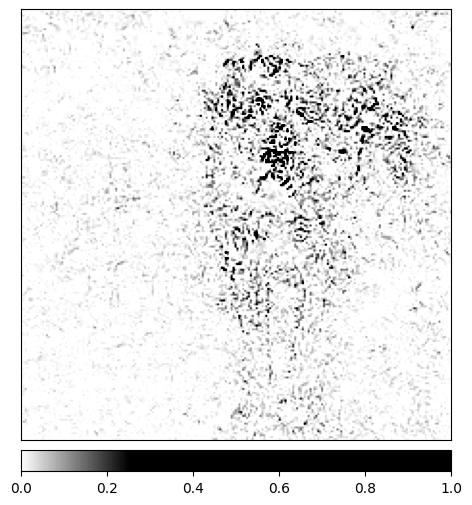

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(transposed_attr_ig,
                             transposed_image,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

### Occlusion-based attribution
Occlusion-based attribution is a different interepretation technique based on perturbing parts of the original image (e.g. by zeroing) and computing how this affects the model decision.
This technique is implemented by:
* Slide a window of shape (h, w) on the target image with a stride s
* Replace the window with a baseline (e.g. with black) and qunatify the effect on model decision.
* Repeat previous steps until all of the target image is covered. 

Simiarly to convolution, this technique can become very slow when used in large models and large input images.

As a first exercise, we run a sliding window of size 15x15 and a stride of 8 along both image dimensions. For each window, we occlude the image with a baseline value of 0.

In [ ]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 8, 8),
                               target=pred_idx,
                               sliding_window_shapes=(3,15, 15),
                               baselines=0)

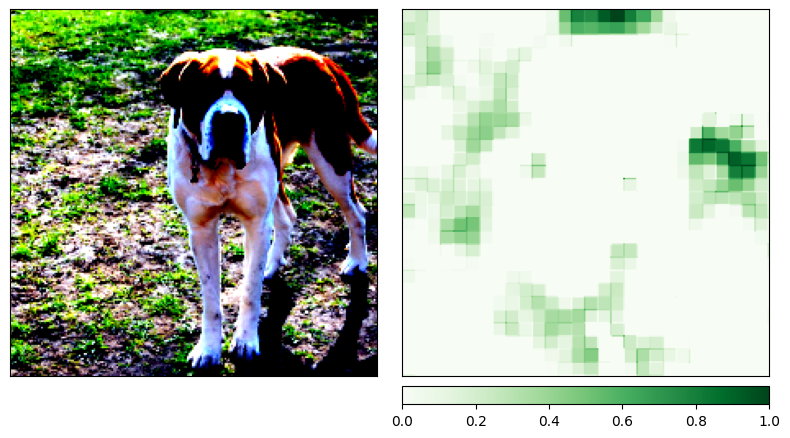

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Let's try different window shape and sliding window and visuzalize the result, by rescaling back to the shape of the original image.

Experimenting with different windows is important because:
* Different shape may lead to a significaly different result.
* Larger windows is useful when the input image presents some local coherence.


In this case, we run a sliding 

---

window of size 60x60 and a stride of 50 along both image dimensions. For each window, we occlude the image with a baseline value of 0.

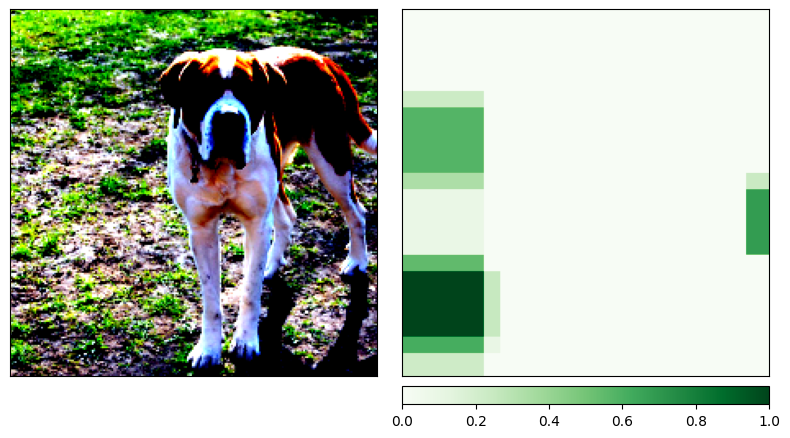

In [ ]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 50, 50),
                               target=pred_idx,
                               sliding_window_shapes=(3,60, 60),
                               baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## Saliency

In [ ]:
# Defining Saliency interpreter
saliency = Saliency(learn_inf.model)
# Computes saliency maps for class 3.
attribution = saliency.attribute(image, target=1)

/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


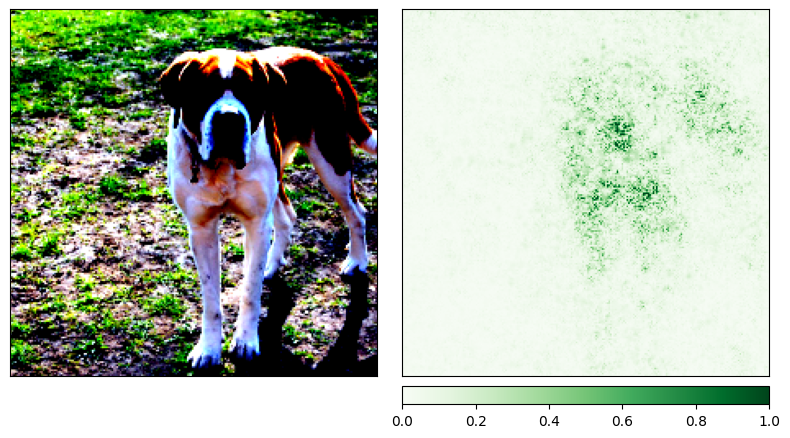

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )